# Classical Random Circuits

Here we use classical circuits to get a handle on error rates.

## setup

In [1]:
import os
import random
from typing import List
import itertools
import networkx as nx
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pyquil.api import get_qc, QuantumComputer
from pyquil.gates import CNOT, CCNOT, X, I, H, CZ, MEASURE, RESET
from pyquil.quilbase import Pragma
from scipy.spatial.distance import hamming

from forest_benchmarking.compilation import basic_compile


## graph state measurement and plotting functions

In [2]:
#qc_perfect = get_qc("Aspen-1-15Q-A", as_qvm=True, noisy=False)
#qc_noisy = get_qc("Aspen-1-15Q-A", as_qvm=True, noisy=True)

qc_perfect = get_qc("9q-square-qvm", as_qvm=True, noisy=False)
qc_noisy = get_qc("9q-square-qvm", as_qvm=True, noisy=True)

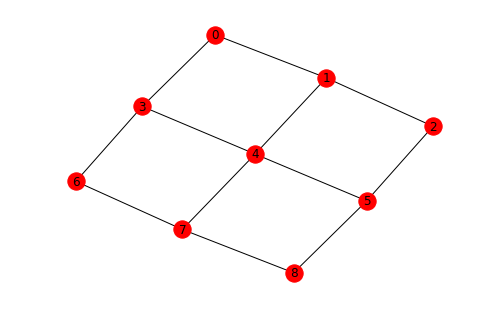

In [3]:
nx.draw(qc_perfect.qubit_topology(),with_labels=True)

In [4]:
from pyquil import *
list_quantum_computers()

['Aspen-3-2Q-A',
 'Aspen-3-3Q-A',
 'Aspen-3-4Q-A',
 'Aspen-3-5Q-A',
 'Aspen-3-6Q-A',
 'Aspen-3-7Q-A',
 'Aspen-3-8Q-A',
 'Aspen-3-9Q-A',
 'Aspen-3-10Q-A',
 'Aspen-3-11Q-A',
 'Aspen-3-12Q-A',
 'Aspen-3-2Q-B',
 'Aspen-3-14Q-A',
 'Aspen-1-2Q-B',
 'Aspen-1-3Q-B',
 'Aspen-1-4Q-B',
 'Aspen-1-5Q-B',
 'Aspen-1-6Q-B',
 'Aspen-1-7Q-B',
 'Aspen-1-9Q-B',
 'Aspen-1-15Q-A',
 'Aspen-1-8Q-B',
 '9q-square-qvm',
 '9q-square-noisy-qvm']

In [5]:
def generate_connected_subgraphs(n_vert: int, G):
    '''
    
    :params n_vert: number of verticies of connected subgraph.
    :params G: networkx Graph
    :returns: list of subgraphs with n_vert connected vertices
    '''
    target = nx.complete_graph(n_vert)
    subgraph_list = []
    for sub_nodes in itertools.combinations(G.nodes(),len(target.nodes())):
        subg = G.subgraph(sub_nodes)
        if nx.is_connected(subg):
            subgraph_list.append(subg)
    return subgraph_list

In [258]:
G = qc_perfect.qubit_topology()
len(qc_perfect.qubit_topology())
# districution of graph lenghts
disty = []
for gdx in range(1,len(G.nodes)+1):
    listg = generate_connected_subgraphs(gdx, G)
    disty.append(len(listg))

disty

[9, 12, 22, 36, 49, 48, 32, 9, 1]

In [12]:
def random_single_bit_gates(graph: nx.Graph):
    """Write a program to randomly place X gates on qubits according to the specified graph.

    :param graph: The graph. Nodes are used as arguments to gates, so they should be qubit-like.
    :return: A program that has randomly placed single qubit X gates.
    """
    program = Program()
    for q in graph.nodes:
        if random.random()>0.5:
            program += X(q)
    return program

In [13]:
def random_two_bit_gates(graph: nx.Graph):
    """Write a program to randomly place CNOT gates between qubits according to the specified graph.

    :param graph: The graph. Nodes are used as arguments to gates, so they should be qubit-like.
    :return: A program that has randomly placed single qubit X gates.
    """
    program = Program()
    program += Pragma('COMMUTING_BLOCKS')
    for a, b in graph.edges:
        if random.random()>0.5:
            program += Pragma('BLOCK')
            program += CNOT(a, b)
            program += Pragma('END_BLOCK')
    program += Pragma('END_COMMUTING_BLOCKS')
    return program

In [14]:
def generate_random_classial_circuit_with_depth(graph: nx.Graph, depth: int):
    """Generate a program to randomly places X gates and CNOTs on a specified graph with a certain depth.
    
    A depth one program contains one 'layer' of random single qubit gates on the vertices and 'layer' of 
    randomly placed two qubit gates. A depth two program would be two such layers.
    
    :param graph: The graph. Nodes are used as arguments to gates, so they should be qubit-like.
    :param depth: The number of times a layer of single qubit gates and two qubit gates are in a pogram
    :return: A program that has randomly placed single qubit and two qubit gates to some depth.
    """
    prog = Program()
    
    # Install identity on all qubits so that we can find all the qubits from prog.get_qubits()
    # if the circuit happens to be identity then you will get the empty set.
    # Do not delete this!!
    prog += [I(qubit) for qubit in list(graph.nodes)] 
    
    for ddx in range(1,depth+1):
        # random one qubit gates
        prog += random_single_bit_gates(graph)
        # random two qubit gates
        prog += random_two_bit_gates(graph)
    return prog

In [15]:
def get_error_hamming_distance_from_results(perfect_bit_string,results):
    """
    Get the hamming weight of the error vector (number of bits flipped
    between output and expected answer).

    :param perfect_bit_string: a np.ndarray with shape (1,number_of_bits)
    :param results: a np.ndarray with shape (num_shots,number_of_bits)
    :return: np.array containg the hamming weight
    """
    num_shots, n_bits = results.shape
    _, pn_bits = perfect_bit_string.shape
    if n_bits != pn_bits:
        raise ValueError("Bit strings are not equal length, check you are runing on the same graph")
    wt = []
    # loop over all results
    for shot in results:
        wt.append(n_bits * hamming(perfect_bit_string, shot))
    return wt

In [16]:
def get_error_hamming_distributions_from_list(wt_list, n_bits):
    """
    Get the distribution of the hamming weight of the error vector.

    :param results: a list of results output 
    :return: the relative frequency of observing each hamming weight
    """
    num_shots = len(wt_list)

    hamming_wt_distrs = []
    hamming_wt_distr = [0. for _ in range(n_bits+1)]
    # record the fraction of shots that resulted in an error of the given weight
    for wdx in range(n_bits):
        hamming_wt_distr[int(wdx)] = wt_list.count(wdx)/num_shots
    return hamming_wt_distr

In [17]:
G = qc_perfect.qubit_topology()

In [77]:
# check that the nodes are not
num_shots_per_circuit = 10
num_rand_subgraphs = 4
num_rand_circuits_per_subgraph = 4
depth = 6

data = []
# loop over different graph sizes
for depth_idx,subgraph_size in itertools.product(range(1,depth+1),range(1,len(G.nodes)+1)):
    list_of_graphs = generate_connected_subgraphs(subgraph_size, G)
    wt = []
    for kdx in range(1,num_rand_subgraphs+1):
        # randomly choose a lattice from list
        lattice = random.choice(list_of_graphs)
        for jdx in range(1,num_rand_circuits_per_subgraph+1):
            prog = generate_random_classial_circuit_with_depth(lattice, depth_idx)
            # perfect 
            perfect_bitstring = qc_perfect.run_and_measure(prog, trials=1)
            perfect_bitstring_array = np.vstack(perfect_bitstring[q] for q in prog.get_qubits()).T
            # run on hardware or noisy QVM
            actual_bitstring = qc_noisy.run_and_measure(prog, trials=3)
            actual_bitstring_array = np.vstack(actual_bitstring[q] for q in prog.get_qubits()).T
            wt.append(get_error_hamming_distance_from_results(perfect_bitstring_array,actual_bitstring_array))

    # for each graph size flatten the results        
    wt_flat = [item for sublist in wt for item in sublist]
    hamming_wt_distr = get_error_hamming_distributions_from_list(wt_flat, subgraph_size)
    # list of tuples. The tuple (depth,width,hamming_dist)
    data.append((depth_idx,subgraph_size,hamming_wt_distr))

In [78]:
data

[(1, 1, [0.9166666666666666, 0.0]),
 (1, 2, [0.8958333333333334, 0.10416666666666667, 0.0]),
 (1, 3, [0.8333333333333334, 0.14583333333333334, 0.020833333333333332, 0.0]),
 (1,
  4,
  [0.7916666666666666, 0.16666666666666666, 0.041666666666666664, 0.0, 0.0]),
 (1, 5, [0.7083333333333334, 0.22916666666666666, 0.0625, 0.0, 0.0, 0.0]),
 (1, 6, [0.6875, 0.3125, 0.0, 0.0, 0.0, 0.0, 0.0]),
 (1,
  7,
  [0.6458333333333334,
   0.2708333333333333,
   0.08333333333333333,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0]),
 (1,
  8,
  [0.6875,
   0.2708333333333333,
   0.020833333333333332,
   0.020833333333333332,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0]),
 (1,
  9,
  [0.6458333333333334,
   0.2916666666666667,
   0.041666666666666664,
   0.020833333333333332,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0]),
 (2, 1, [0.9375, 0.0]),
 (2, 2, [0.8541666666666666, 0.14583333333333334, 0.0]),
 (2, 3, [0.8541666666666666, 0.14583333333333334, 0.0, 0.0]),
 (2,
  4,
  [0.7916666666666666, 0.16666666666666666, 0.

In [79]:
len(data)
Pcheck = np.ndarray(shape=(depth,len(G.nodes)), dtype=float, order='C')

for dslice in data:
    depth_idx = dslice[0]-1
    width_idx = dslice[1]-1
    Pcheck[depth_idx,width_idx]= dslice[2][0]

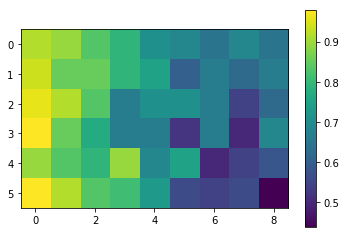

In [80]:
plt.imshow(Pcheck)
plt.colorbar(orientation='vertical')
plt.show()

In [81]:
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt


delta = 0.025
x = np.arange(-3.0, 3.0, delta)
y = np.arange(-2.0, 2.0, delta)
X, Y = np.meshgrid(x, y)
Z1 = np.exp(-X**2 - Y**2)
Z2 = np.exp(-(X - 1)**2 - (Y - 1)**2)
Z = (Z1 - Z2) * 2

Text(0.5,1,'Simplest default with labels')

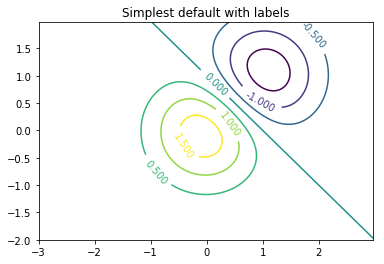

In [82]:
fig, ax = plt.subplots()
CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Simplest default with labels')

In [90]:
depthvec = np.arange(1,depth+1,1)
widthvec = np.arange(1,len(G.nodes)+1,1)

In [91]:
X, Y = np.meshgrid(widthvec, depthvec)

Text(0.5,1,'Simplest default with labels')

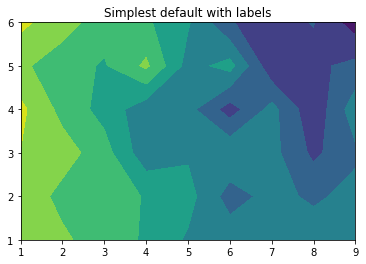

In [96]:
fig, ax = plt.subplots()
CS = ax.contourf(X, Y, Pcheck)
#ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Simplest default with labels')

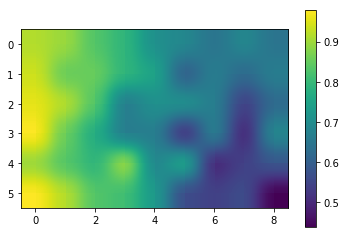

In [101]:
plt.imshow(Pcheck, interpolation='hamming', cmap='viridis')
plt.colorbar(orientation='vertical')
plt.show()

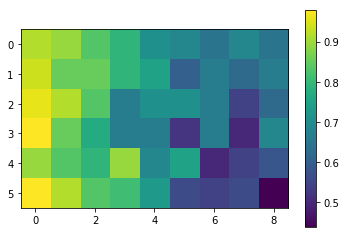

In [102]:
plt.imshow(Pcheck, interpolation='none', cmap='viridis')
plt.colorbar(orientation='vertical')
plt.show()